# 🔍 Azure AutoML for Images (Object Detection)
## 1. Download images files and labels

![Alt text](img/img.jpg)

## Overview
This notebook demonstrates an end-to-end AutoML for images workflow for object detection using Azure Machine Learning SDK v2 and Python 3.10. It focuses on automating model training for detecting objects in images, leveraging a Kaggle dataset.

## 1. Settings

In [1]:
import datetime
import glob
import kagglehub
import matplotlib.pyplot as plt
import os
import platform
import pandas as pd
import psutil
import shutil
import sys
import time
import xml.etree.ElementTree as ET

from PIL import Image, ImageDraw

In [2]:
sys.version

'3.10.18 (main, Jun  5 2025, 13:14:17) [GCC 11.2.0]'

In [3]:
print(f"Today is {datetime.datetime.today().strftime('%d-%b-%Y %H:%M:%S')}")

Today is 29-Oct-2025 08:43:32


In [4]:
processor = platform.processor()
cpu_count = psutil.cpu_count(logical=True)
ram_total = round(psutil.virtual_memory().total / (1024 ** 3), 2)
ram_available = round(psutil.virtual_memory().available / (1024 ** 3), 2)

disk_total, disk_used, disk_free = shutil.disk_usage("/")
disk_total_gb = disk_total / (1024 ** 3)
disk_free_gb = disk_free / (1024 ** 3)
disk_free_percent = disk_free / disk_total

print(f"🖥️ Processor: {processor}")
print(f"🧠 CPU Cores: {cpu_count}")
print(f"💾 RAM Total: {ram_total} GB")
print(f"📗 RAM Available: {ram_available} GB")
print(f"📀 Disk Total: {disk_total_gb:.2f} GB")
print(f"📂 Disk Free: {disk_free_gb:.2f} GB ({disk_free_percent:.0%})")

🖥️ Processor: x86_64
🧠 CPU Cores: 48
💾 RAM Total: 188.88 GB
📗 RAM Available: 183.87 GB
📀 Disk Total: 118.05 GB
📂 Disk Free: 39.79 GB (34%)


In [5]:
RESULTS_DIR = 'results'

os.makedirs(RESULTS_DIR, exist_ok=True)

## 2. Downloading images

- Source: https://www.kaggle.com/alexj21/swimming-pool-512x512
- Original images: https://geoservices.ign.fr/bdortho

In [6]:
IMAGES_DIR = 'images'

os.makedirs(IMAGES_DIR, exist_ok=True)

### Downloading images & labels

In [7]:
start = time.time()

kagglehub.dataset_download("alexj21/swimming-pool-512x512")

minutes, seconds = divmod((time.time() - start), 60)
print(f"\nElapsed time = {minutes:.0f} minutes and {seconds:.0f} seconds")

100%|██████████| 1.62G/1.62G [00:43<00:00, 40.4MB/s]

Extracting files...



Elapsed time = 0 minutes and 56 seconds


## 3. Data management

In [8]:
TEMP_DIR = "/home/azureuser/.cache/kagglehub/datasets/alexj21/swimming-pool-512x512/versions/5"

In [9]:
!ls $TEMP_DIR -lh

total 862M
drwxr-xr-x 3 azureuser azureuser 4.0K Oct 29 08:44 CANNES_TILES_512x512_PNG
drwxr-xr-x 3 azureuser azureuser 4.0K Oct 29 08:44 CANNES_TILES_512x512_labels
-rw-r--r-- 1 azureuser azureuser 145M Oct 29 08:44 TEST_SET.4.png
-rw-r--r-- 1 azureuser azureuser 287M Oct 29 08:44 TEST_SET.4.tif
-rw-r--r-- 1 azureuser azureuser 145M Oct 29 08:44 TEST_SET_ALPES_MARITIMES.3.png
-rw-r--r-- 1 azureuser azureuser 287M Oct 29 08:44 TEST_SET_ALPES_MARITIMES.3.tif


In [10]:
source = os.path.join(
    TEMP_DIR,
    "CANNES_TILES_512x512_PNG",
    "CANNES_TILES_512x512_PNG"
)
destination = os.path.join(IMAGES_DIR, "png")

start = time.time()

print(f"🔄 Moving images from '{source}' to '{destination}'...")
shutil.move(source, destination)

minutes, seconds = divmod((time.time() - start), 60)
print(f"\nElapsed time = {minutes:.0f} minutes and {seconds:.0f} seconds")

🔄 Moving images from '/home/azureuser/.cache/kagglehub/datasets/alexj21/swimming-pool-512x512/versions/5/CANNES_TILES_512x512_PNG/CANNES_TILES_512x512_PNG' to 'images/png'...

Elapsed time = 4 minutes and 29 seconds


In [11]:
source = os.path.join(
    TEMP_DIR,
    "CANNES_TILES_512x512_labels",
    "CANNES_TILES_512x512_labels"
)
destination = os.path.join(IMAGES_DIR, "labels")

start = time.time()

print(f"🔄 Moving labels from '{source}' to '{destination}'...")
shutil.move(source, destination)

minutes, seconds = divmod((time.time() - start), 60)
print(f"\nElapsed time = {minutes:.0f} minutes and {seconds:.0f} seconds")

🔄 Moving labels from '/home/azureuser/.cache/kagglehub/datasets/alexj21/swimming-pool-512x512/versions/5/CANNES_TILES_512x512_labels/CANNES_TILES_512x512_labels' to 'images/labels'...

Elapsed time = 1 minutes and 26 seconds


In [12]:
TEMP_MAIN_DIR = "/home/azureuser/.cache/kagglehub/"

if os.path.exists(TEMP_MAIN_DIR):
    shutil.rmtree(TEMP_MAIN_DIR)
    print(f"✅ Done. Directory {TEMP_MAIN_DIR} is deleted.")
else:
    print(f"❌ Path does not exist: {TEMP_MAIN_DIR}")

✅ Done. Directory /home/azureuser/.cache/kagglehub/ is deleted.


## 4. Images and labels

In [13]:
os.listdir(IMAGES_DIR)

PNG_DIR = os.path.join(IMAGES_DIR, "png")
LABELS_DIR = os.path.join(IMAGES_DIR, "labels")

In [14]:
# Keep only the image file that has a label file
image_ext = ".png"
label_ext = ".xml"

label_basenames = {
    os.path.splitext(f)[0]
    for f in os.listdir(LABELS_DIR) if f.endswith(label_ext)
}

for file in os.listdir(PNG_DIR):
    if file.endswith(image_ext):
        base_name = os.path.splitext(file)[0]
        if base_name not in label_basenames:
            os.remove(os.path.join(PNG_DIR, file))

### Image example

In [15]:
image_file = os.path.join(PNG_DIR, "CANNES_TILES_512x512.618.png")
label_file = os.path.join(LABELS_DIR, "CANNES_TILES_512x512.618.xml")

In [16]:
!ls $image_file -lh

-rwxrwxrwx 1 root root 413K Oct 29 08:44 images/png/CANNES_TILES_512x512.618.png


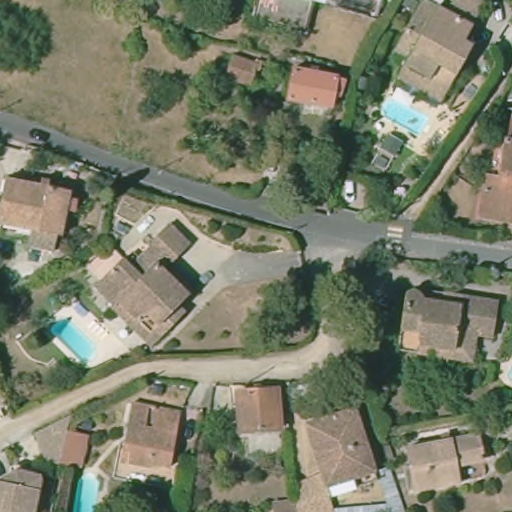

In [17]:
img = Image.open(image_file)
img

In [18]:
!ls $label_file -lh

-rwxrwxrwx 1 root root 1014 Oct 29 08:44 images/labels/CANNES_TILES_512x512.618.xml


In [19]:
with open(label_file, 'r') as f:
    print(f.read())

<annotation>
	<folder>CANNES_TILES_512x512</folder>
	<filename>CANNES_TILES_512x512.618.tif</filename>
	<path>F:\CANNES_TILES_512x512\CANNES_TILES_512x512.618.tif</path>
	<source>
		<database>Unknown</database>
	</source>
	<size>
		<width>512</width>
		<height>512</height>
		<depth>3</depth>
	</size>
	<segmented>0</segmented>
	<object>
		<name>pool</name>
		<pose>Unspecified</pose>
		<truncated>1</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>71</xmin>
			<ymin>468</ymin>
			<xmax>105</xmax>
			<ymax>512</ymax>
		</bndbox>
	</object>
	<object>
		<name>pool</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>47</xmin>
			<ymin>315</ymin>
			<xmax>100</xmax>
			<ymax>361</ymax>
		</bndbox>
	</object>
	<object>
		<name>pool</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>377</xmin>
			<ymin>93</ymin>
			<xmax>433</xmax>
			<ymax>139</ymax>
		</bndbox>
	</object>


> The existing references images to .tif files instead of .png files. So let's do the updates to all labels files.

In [20]:
def replace_str1_with_str2(directory_path: str, str1: str, str2: str):
    """
    Replace all occurrences of 'str1' with 'str2' in XML files
    
    Args:
        directory_path: Path to directory containing XML files
    """
    # Find all XML files in the directory
    xml_files = glob.glob(os.path.join(directory_path, '*.xml'))

    if not xml_files:
        print("❌ No XML files found in the directory.")
        return

    processed_count = 0

    for xml_file in xml_files:
        try:
            # Read the file
            with open(xml_file, 'r', encoding='utf-8') as file:
                content = file.read()
            # Replace 'tif' with 'png'
            updated_content = content.replace(str1, str2)
            # Write back only if there were changes
            if updated_content != content:
                with open(xml_file, 'w', encoding='utf-8') as file:
                    file.write(updated_content)
                processed_count += 1
            else:
                print(f"ℹ️ No changes needed: {xml_file}")

        except Exception as e:
            print(f"❌ Error processing {xml_file}: {e}")

    print(f"✅ Done: Updated {processed_count} files in {directory_path}.")

In [21]:
start = time.time()

replace_str1_with_str2(LABELS_DIR, "tif", "png")

minutes, seconds = divmod((time.time() - start), 60)
print(f"✅ Elapsed time = {minutes:.0f} minutes and {seconds:.0f} seconds")

✅ Done: Updated 1224 files in images/labels.
✅ Elapsed time = 1 minutes and 33 seconds


> OK now. The XML files no longer include references to the TIFF files

## Label file

In [22]:
label_file

'images/labels/CANNES_TILES_512x512.618.xml'

In [23]:
with open(label_file, 'r') as f:
    print(f.read())

<annotation>
	<folder>CANNES_TILES_512x512</folder>
	<filename>CANNES_TILES_512x512.618.png</filename>
	<path>F:\CANNES_TILES_512x512\CANNES_TILES_512x512.618.png</path>
	<source>
		<database>Unknown</database>
	</source>
	<size>
		<width>512</width>
		<height>512</height>
		<depth>3</depth>
	</size>
	<segmented>0</segmented>
	<object>
		<name>pool</name>
		<pose>Unspecified</pose>
		<truncated>1</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>71</xmin>
			<ymin>468</ymin>
			<xmax>105</xmax>
			<ymax>512</ymax>
		</bndbox>
	</object>
	<object>
		<name>pool</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>47</xmin>
			<ymin>315</ymin>
			<xmax>100</xmax>
			<ymax>361</ymax>
		</bndbox>
	</object>
	<object>
		<name>pool</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>377</xmin>
			<ymin>93</ymin>
			<xmax>433</xmax>
			<ymax>139</ymax>
		</bndbox>
	</object>


## Image with its label

In [24]:
image_file = os.path.join(PNG_DIR, "CANNES_TILES_512x512.618.png")
image_file

'images/png/CANNES_TILES_512x512.618.png'

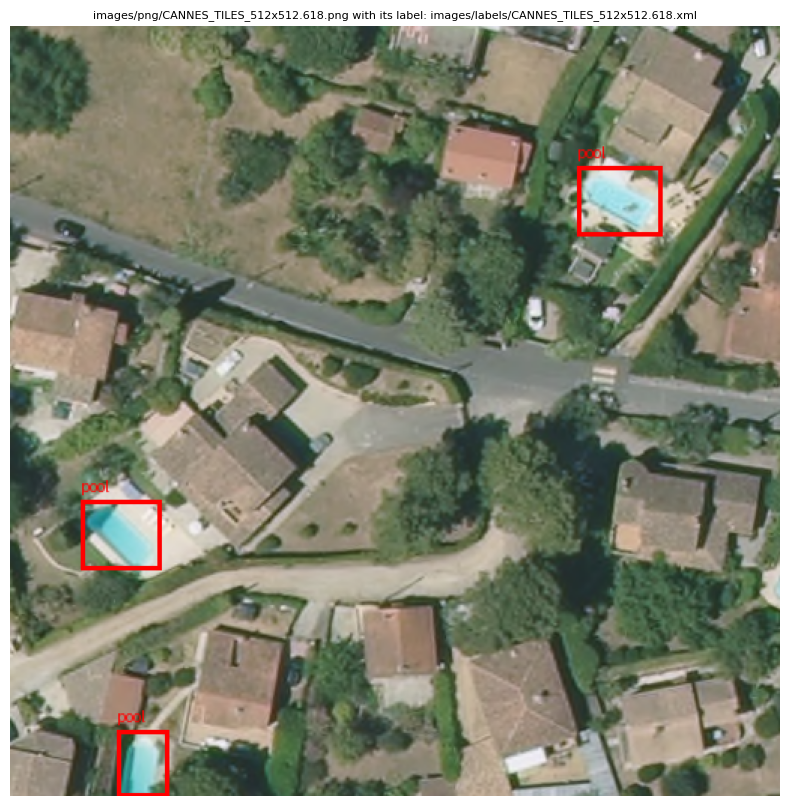

In [25]:
img = Image.open(image_file)

draw = ImageDraw.Draw(img)
tree = ET.parse(label_file)
root = tree.getroot()
color = "red"

for obj in root.findall('object'):
    if obj.find('name').text == 'pool':
        bbox = obj.find('bndbox')
        xmin = int(bbox.find('xmin').text)
        ymin = int(bbox.find('ymin').text)
        xmax = int(bbox.find('xmax').text)
        ymax = int(bbox.find('ymax').text)
        draw.rectangle([xmin, ymin, xmax, ymax], outline=color, width=3)
        draw.text((xmin, ymin - 15), 'pool', fill=color)

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis("off")
plt.title(f"{image_file} with its label: {label_file}", size=8)
plt.show()

In [26]:
nb_png = len([f for f in os.listdir(PNG_DIR) if f.endswith('.png')])
print(f"🖼️ Total of .png images files = {nb_png}")

nb_xml = len([f for f in os.listdir(LABELS_DIR) if f.endswith('.xml')])
print(f"🏷️ Total of .xml labels files = {nb_xml}")

🖼️ Total of .png images files = 1224
🏷️ Total of .xml labels files = 1224


## Some images with their labels

In [27]:
nb = 20

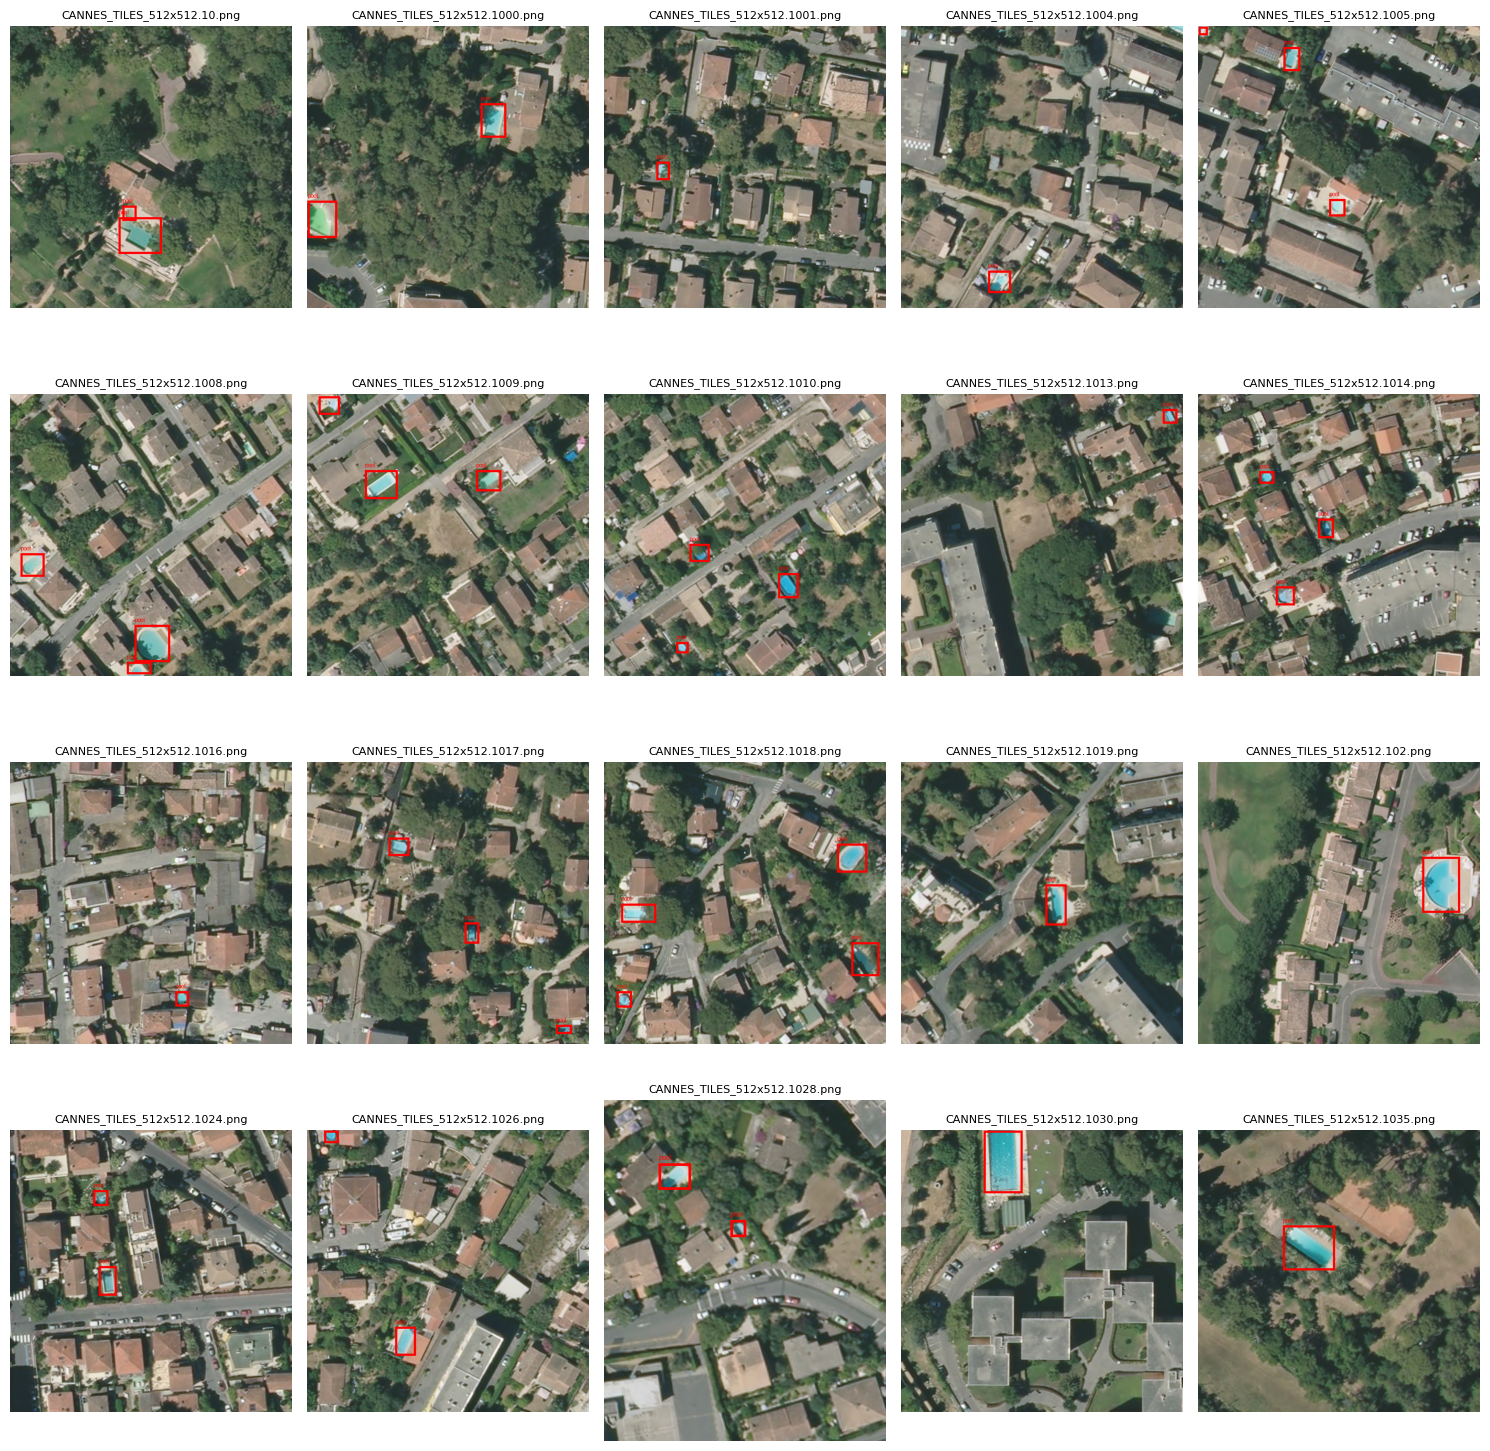

In [28]:
image_files = sorted([
    f for f in os.listdir(PNG_DIR) if f.lower().endswith(('.png', '.jpg', '.jpeg'))
])[:nb]

# Number of cols and rows
cols = 5
rows = int(nb / cols) + (1 if nb % cols else 0)

width = 4
color = "red"
fig, axes = plt.subplots(rows, cols, figsize=(15, 15))
axes = axes.flatten()

for idx, image_file in enumerate(image_files):
    image_path = os.path.join(PNG_DIR, image_file)
    label_file = image_file.rsplit('.', 1)[0] + '.xml'
    label_path = os.path.join(LABELS_DIR, label_file)
    img = Image.open(image_path)
    draw = ImageDraw.Draw(img)

    if os.path.exists(label_path):
        tree = ET.parse(label_path)
        root = tree.getroot()

        for obj in root.findall('object'):
            if obj.find('name').text == 'pool':
                bbox = obj.find('bndbox')
                xmin = int(bbox.find('xmin').text)
                ymin = int(bbox.find('ymin').text)
                xmax = int(bbox.find('xmax').text)
                ymax = int(bbox.find('ymax').text)
                draw.rectangle([xmin, ymin, xmax, ymax],
                               outline=color,
                               width=width)
                draw.text((xmin, ymin - 15), 'pool', fill=color)

    axes[idx].imshow(img)
    axes[idx].axis('off')
    axes[idx].set_title(f"{image_file}", fontsize=8)

plt.tight_layout()
plt.show()

In [29]:
# Generating a df with some images informations

print("Generating the df...")
start = time.time()
data = []

for f in os.listdir(PNG_DIR):
    if f.lower().endswith(('.png', '.jpg', '.jpeg')):
        file_path = os.path.join(PNG_DIR, f)
        size_bytes = os.path.getsize(file_path)
        size_kb = round(size_bytes / 1024, 2)
        modified_time = datetime.datetime.fromtimestamp(os.path.getmtime(file_path))
        
        with Image.open(file_path) as img:
            width, height = img.size
        
        data.append({
            "image_filename": f,
            "size_kb": size_kb,
            "modified_date": modified_time.strftime("%Y-%m-%d %H:%M:%S"),
            "width": width,
            "height": height,
            "resolution": f"{width}x{height}",
        })

df = pd.DataFrame(data)

minutes, seconds = divmod((time.time() - start), 60)
print(f"✅ Done. Elapsed time = {minutes:.0f} minutes and {seconds:.0f} seconds")

Generating the df...
✅ Done. Elapsed time = 1 minutes and 2 seconds


In [30]:
df

image_filename  size_kb        modified_date  width  \
0       CANNES_TILES_512x512.10.png   378.20  2025-10-29 08:44:17    512   
1     CANNES_TILES_512x512.1000.png   382.01  2025-10-29 08:44:17    512   
2     CANNES_TILES_512x512.1001.png   399.27  2025-10-29 08:44:17    512   
3     CANNES_TILES_512x512.1004.png   390.04  2025-10-29 08:44:17    512   
4     CANNES_TILES_512x512.1005.png   383.32  2025-10-29 08:44:17    512   
...                             ...      ...                  ...    ...   
1219   CANNES_TILES_512x512.994.png   371.15  2025-10-29 08:44:22    512   
1220   CANNES_TILES_512x512.995.png   393.53  2025-10-29 08:44:22    512   
1221   CANNES_TILES_512x512.996.png   379.28  2025-10-29 08:44:22    512   
1222   CANNES_TILES_512x512.997.png   397.96  2025-10-29 08:44:22    512   
1223   CANNES_TILES_512x512.998.png   370.41  2025-10-29 08:44:22    512   

      height resolution  
0        512    512x512  
1        512    512x512  
2        512    512x512  
3        512    512x512  
4        512    512x512  
...      ...        ...  
1219     512    512x512  
1220     512    512x512  
1221     512    512x512  
1222     512    512x512  
1223     512    512x512  

[1224 rows x 6 columns]

In [31]:
df['width'].value_counts(sort=True)

512    1203
424      21
Name: width, dtype: int64

In [32]:
df['height'].value_counts(sort=True)

512    1224
Name: height, dtype: int64

### Export

In [33]:
csv_file = os.path.join(RESULTS_DIR, "images.csv")
df.to_csv(csv_file, index=False)
!ls $csv_file -lh

-rwxrwxrwx 1 root root 87K Oct 29 08:53 results/images.csv


In [34]:
excel_file = os.path.join(RESULTS_DIR, "images.xlsx")
df.to_excel(excel_file, index=False)
!ls $excel_file -lh

-rwxrwxrwx 1 root root 40K Oct 29 08:53 results/images.xlsx


> Go to next notebook